# NYC Delivery Truck Congestion – Step 4: Spatial Features & Data Aggregation
*Author: Karan Chauhan*  

This notebook creates spatial features and aggregates complaints into a prediction-ready dataset.

**Part A: Spatial Features**
- Create geographic grid cells (0.01° resolution)
- Assign each complaint to a grid cell

**Part B: Data Aggregation**
- Group complaints by (grid cell + hour + day of week)
- Create target variable for prediction
- Prepare train/test split

---

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap
from sklearn.model_selection import train_test_split

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

---
# Part A: Spatial Features (Grid Cells)
---

## Load Dataset with Temporal Features

In [2]:
df = pd.read_csv('../data/complaints_with_features.csv')

print(f"Loaded {len(df):,} complaints with temporal features")
df.head()

Loaded 110,787 complaints with temporal features


,created_date,complaint_type,descriptor,borough,latitude,longitude,street_name,hour,day_of_week,day_name,is_weekend,is_rush_hour,month
0,2023-01-01 00:31:23,Illegal Parking,Double Parked Blocking Traffic,MANHATTAN,40.837321,-73.942507,BROADWAY,0,6,Sunday,1,0,1
1,2023-01-01 00:43:13,Illegal Parking,Double Parked Blocking Vehicle,MANHATTAN,40.837597,-73.945560,WEST 161 STREET,0,6,Sunday,1,0,1
2,2023-01-01 00:59:17,Illegal Parking,Double Parked Blocking Traffic,MANHATTAN,40.755292,-73.994922,9 AVENUE,0,6,Sunday,1,0,1
3,2023-01-01 01:13:56,Illegal Parking,Double Parked Blocking Traffic,MANHATTAN,40.836665,-73.943331,WEST 161 STREET,1,6,Sunday,1,0,1
4,2023-01-01 01:24:59,Illegal Parking,Blocked Hydrant,MANHATTAN,40.854916,-73.936035,WEST 187 STREET,1,6,Sunday,1,0,1


## Clean Spatial Data

In [3]:
# Drop rows with missing lat/lon
df_clean = df.dropna(subset=['latitude', 'longitude']).copy()
print(f"After removing missing location data: {len(df_clean):,} complaints")
print(f"Dropped: {len(df) - len(df_clean):,} rows ({(len(df) - len(df_clean))/len(df)*100:.1f}%)")

After removing missing location data: 109,790 complaints
Dropped: 997 rows (0.9%)


## Create Grid Cells

In [4]:
GRID_PRECISION = 0.01

df_clean['grid_lat'] = (df_clean['latitude'] / GRID_PRECISION).round() * GRID_PRECISION
df_clean['grid_lon'] = (df_clean['longitude'] / GRID_PRECISION).round() * GRID_PRECISION
df_clean['grid_id'] = df_clean['grid_lat'].astype(str) + '_' + df_clean['grid_lon'].astype(str)

print(f"Created {df_clean['grid_id'].nunique():,} unique grid cells")
print(f"Average complaints per cell: {len(df_clean) / df_clean['grid_id'].nunique():.1f}")

Created 90 unique grid cells
Average complaints per cell: 1219.9


## Visualize Grid Coverage

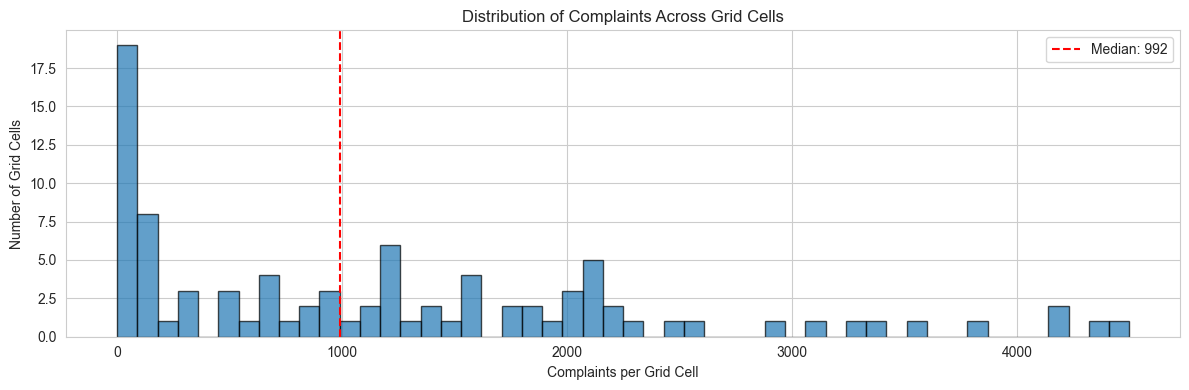


Top 10 busiest grid cells:
grid_id
40.84_-73.94                 4500
40.800000000000004_-73.95    4326
40.72_-73.99                 4179
40.82_-73.95                 4152
40.81_-73.96000000000001     3832
40.71_-74.01                 3526
40.87_-73.92                 3389
40.86_-73.93                 3329
40.81_-73.95                 3071
40.82_-73.94                 2906
Name: count, dtype: int64


In [5]:
cell_counts = df_clean['grid_id'].value_counts()

plt.figure(figsize=(12, 4))
plt.hist(cell_counts, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Complaints per Grid Cell')
plt.ylabel('Number of Grid Cells')
plt.title('Distribution of Complaints Across Grid Cells')
plt.axvline(cell_counts.median(), color='red', linestyle='--', label=f'Median: {cell_counts.median():.0f}')
plt.legend()
plt.tight_layout()
plt.show()

print("\nTop 10 busiest grid cells:")
print(cell_counts.head(10))

---
# Part B: Data Aggregation for Modeling
---

## Create Aggregated Dataset

Transform individual complaints into aggregated observations:
- Each row = (grid cell + hour + day of week)
- Target variable = complaint count in that combination
- This enables prediction: "What's the risk in grid X at hour Y on day Z?"

In [6]:
# Group by grid cell, hour, and day of week
agg_data = df_clean.groupby(['grid_id', 'grid_lat', 'grid_lon', 'hour', 'day_of_week']).agg({
    'created_date': 'count',  # Count complaints
    'is_weekend': 'first',     # Weekend flag (same for all in group)
    'is_rush_hour': 'first',   # Rush hour flag
    'month': lambda x: x.mode()[0] if len(x.mode()) > 0 else x.iloc[0]  # Most common month
}).reset_index()

# Rename complaint count column
agg_data.rename(columns={'created_date': 'complaint_count'}, inplace=True)

print(f"Aggregated {len(df_clean):,} complaints into {len(agg_data):,} observations")
print(f"\nEach observation represents: (grid cell + hour + day of week)")

agg_data.head(10)

Aggregated 109,790 complaints into 10,204 observations

Each observation represents: (grid cell + hour + day of week)


,grid_id,grid_lat,grid_lon,hour,day_of_week,complaint_count,is_weekend,is_rush_hour,month
0,40.69_-74.02,40.69,-74.02,10,0,1,0,0,4
1,40.71_-73.98,40.71,-73.98,0,5,1,1,0,11
2,40.71_-73.98,40.71,-73.98,1,0,1,0,0,10
3,40.71_-73.98,40.71,-73.98,1,1,1,0,0,12
4,40.71_-73.98,40.71,-73.98,1,2,1,0,0,6
5,40.71_-73.98,40.71,-73.98,1,5,1,1,0,8
6,40.71_-73.98,40.71,-73.98,2,1,1,0,0,6
7,40.71_-73.98,40.71,-73.98,2,2,1,0,0,11
8,40.71_-73.98,40.71,-73.98,3,0,1,0,0,4
9,40.71_-73.98,40.71,-73.98,5,1,1,0,0,12


## Create Target Variable

Define prediction task: Binary classification (high/low congestion)

In [7]:
# Define high congestion threshold (75th percentile)
threshold = agg_data['complaint_count'].quantile(0.75)
agg_data['high_congestion'] = (agg_data['complaint_count'] >= threshold).astype(int)

print(f"High congestion threshold: {threshold:.1f} complaints")
print(f"\nClass distribution:")
print(agg_data['high_congestion'].value_counts())
print(f"\nHigh congestion percentage: {agg_data['high_congestion'].mean()*100:.1f}%")

High congestion threshold: 15.0 complaints

Class distribution:
high_congestion
0    7626
1    2578
Name: count, dtype: int64

High congestion percentage: 25.3%


## Feature Summary

In [8]:
print("Modeling dataset shape:", agg_data.shape)
print("\nFeatures available:")
print(list(agg_data.columns))

print("\nFeature value counts:")
print(f"Unique grid cells: {agg_data['grid_id'].nunique()}")
print(f"Unique hours: {agg_data['hour'].nunique()}")
print(f"Unique days: {agg_data['day_of_week'].nunique()}")

Modeling dataset shape: (10204, 10)

Features available:
['grid_id', 'grid_lat', 'grid_lon', 'hour', 'day_of_week', 'complaint_count', 'is_weekend', 'is_rush_hour', 'month', 'high_congestion']

Feature value counts:
Unique grid cells: 90
Unique hours: 24
Unique days: 7


## Aggregated Data Statistics

Complaint count distribution:
count    10204.000000
mean        10.759506
std         12.869271
min          1.000000
25%          3.000000
50%          7.000000
75%         15.000000
max        242.000000
Name: complaint_count, dtype: float64


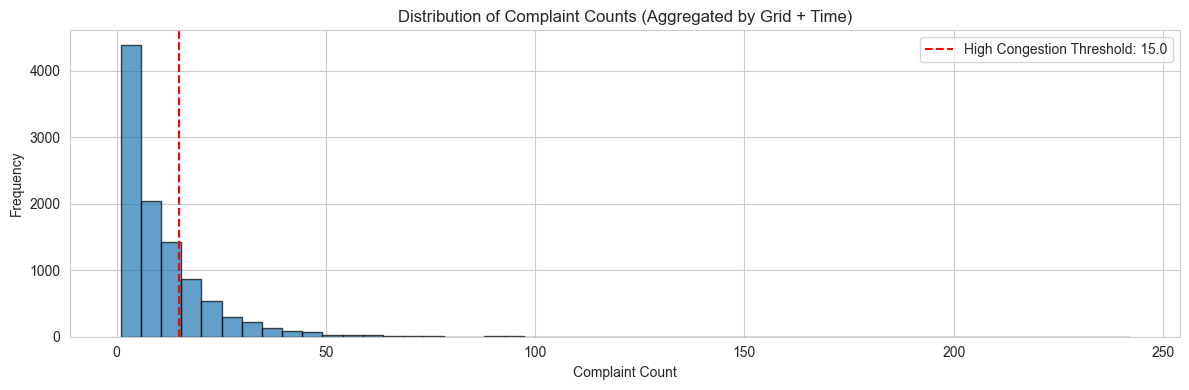

In [9]:
print("Complaint count distribution:")
print(agg_data['complaint_count'].describe())

plt.figure(figsize=(12, 4))
plt.hist(agg_data['complaint_count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Complaint Count')
plt.ylabel('Frequency')
plt.title('Distribution of Complaint Counts (Aggregated by Grid + Time)')
plt.axvline(threshold, color='red', linestyle='--', label=f'High Congestion Threshold: {threshold:.1f}')
plt.legend()
plt.tight_layout()
plt.show()

## Save Modeling Dataset

In [10]:
# Save aggregated modeling dataset
modeling_path = '../data/modeling_dataset.csv'
agg_data.to_csv(modeling_path, index=False)

print(f"Saved modeling dataset: {modeling_path}")
print(f"Rows: {len(agg_data):,}")
print(f"Columns: {len(agg_data.columns)}")
print(f"\nReady for model training in Step 5!")

Saved modeling dataset: ../data/modeling_dataset.csv
Rows: 10,204
Columns: 10

Ready for model training in Step 5!


## Summary

**What we accomplished:**
1. Created spatial grid cells (90 unique cells covering Manhattan)
2. Aggregated 110k complaints into prediction-ready format
3. Defined target variable (high/low congestion)
4. Saved modeling dataset ready for ML

**Features available for modeling:**
- Spatial: `grid_id`, `grid_lat`, `grid_lon`
- Temporal: `hour`, `day_of_week`, `is_weekend`, `is_rush_hour`, `month`
- Target: `high_congestion` (binary), `complaint_count` (continuous)

**Next step:** Build and evaluate predictive models (Step 5)